### Machine Learning Model

In [1]:
# Load libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from IPython.display import display
from sklearn.model_selection import train_test_split

from r3_helpers import chain_snap
from r5_helpers import (diagnostic_plots, encode_categorical_features,
                        get_variance_inflation_factors, normlize_data,
                        regression_report)

np.random.seed(42)

pd.options.display.float_format = "{:.3f}".format
pd.set_option("display.width", 1000)

In [2]:
data_train = (
    pd.read_parquet("./data/data_train_cleaned.parquet")
    .pipe(
        chain_snap,
        fn=lambda x: x.duplicated().sum(),
        msg="o Number of duplicate rows",
    )
    .pipe(
        chain_snap,
        fn=lambda x: x.isna().sum().sum(),
        msg="o Number of missing values in the dataset",
    )
)

TARGET = "Price" 
data_train = data_train.dropna()
# display some info
display(data_train.head(3))
print(f"o Size dataframe = {data_train.shape}")

o Number of duplicate rows: 0
o Number of missing values in the dataset: 8


,Price,Unnamed: 0,Address,Zip,Area,Room,Lon,Lat,log(Price),Zip_num,...,City_number,Region,Location,District,Delivery_area,log(Area),log(Room),Euclidean_distance,Haversine_distance,Manhattan_distance
0,425000.000,98,"Lamarckhof 11 I, Amsterdam",1098TK,68,3,4.944,52.352,12.960,1098,...,1,0,9,8,TK,4.220,1.099,0.055,4.174,0.072
1,520000.000,228,"Kiefskamp 24, Amsterdam",1082KA,80,2,4.872,52.330,13.162,1082,...,1,0,8,2,KA,4.382,0.693,0.048,4.959,0.063
2,700000.000,693,"Latherusstraat 54, Amsterdam",1032EC,123,6,4.915,52.393,13.459,1032,...,1,0,3,2,EC,4.812,1.792,0.030,2.712,0.042


o Size dataframe = (735, 21)


In [3]:
data_test = (
    pd.read_csv("./data/data_test.csv", low_memory=False)
    .pipe(
        chain_snap,
        fn=lambda x: x.duplicated().sum(),
        msg="o Number of duplicate rows",
    )
    .pipe(
        chain_snap,
        fn=lambda x: x.isna().sum().sum(),
        msg="o Number of missing values in the dataset",
    )
    .drop_duplicates()
    # create log of Price
    .assign(**{"log(Price)": lambda df: np.log(df["Price"])})
)

data_test = data_test.assign(
    **{
        "log(Area)": lambda df: np.log(df["Area"]),
        "log(Room)": lambda df: np.log(df["Room"]),
    }
)


def euclidean_distance(lat1: float, lon1: float, lat2: float, lon2: float) -> float:
    """Compute the euclidean distance between two points"""
    return np.sqrt((lat1 - lat2) ** 2 + (lon1 - lon2) ** 2)

def haversine_distance(lat1: float, lon1: float, lat2: float, lon2: float) -> float:
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians
    lat1, lon1, lat2, lon2 = map(np.radians, (lat1, lon1, lat2, lon2))

    # haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2
    c = 2 * np.arcsin(np.sqrt(a))
    r = 6371  # Radius of earth in kilometers. Use 3956 for miles
    return c * r

# Define Lat and Lon of Dam Square using Google Maps
Lat_Centrum = 52.373095
Lon_Centrum = 4.893055


data_test = data_test.assign(
    **{
        "Euclidean_distance": lambda data_test: euclidean_distance(
            data_test["Lat"], data_test["Lon"], Lat_Centrum, Lon_Centrum
        ),
        "Haversine_distance": lambda data_test: haversine_distance(
            data_test["Lat"], data_test["Lon"], Lat_Centrum, Lon_Centrum
        ),
        "Manhattan_distance": lambda data_test: np.abs(data_test["Lat"] - Lat_Centrum)
        + np.abs(data_test["Lon"] - Lon_Centrum),
    }
)


# remove any space in the Zip string
data_test["Zip"] = data_test["Zip"].str.replace(" ", "")

# create new features from Address and Zip
data_test = data_test.assign(
    **{
        "Zip_num": lambda data_test: data_test["Zip"].str[:4].astype(int),
        "City": lambda data_test: data_test["Address"].str.split().str[-1],
        "City_number": lambda data_test: data_test["Zip"].str[0].astype(int),
        "Region": lambda data_test: data_test["Zip"].str[1].astype(int),
        "Location": lambda data_test: data_test["Zip"].str[2].astype(int),
        "District": lambda data_test: data_test["Zip"].str[3].astype(int),
        "Delivery_area": lambda data_test: data_test["Zip"].str[4:],
    }
)



# display some info
display(data_test.head(3))
print(f"o Size dataframe = {data_test.shape}")

o Number of duplicate rows: 0
o Number of missing values in the dataset: 0


,Price,Unnamed: 0,Address,Zip,Area,Room,Lon,Lat,log(Price),log(Area),...,Euclidean_distance,Haversine_distance,Manhattan_distance,Zip_num,City,City_number,Region,Location,District,Delivery_area
0,450000.000,324,"Claus van Amsbergstraat 45, Amsterdam",1102AZ,120,5,4.956,52.318,13.017,4.787,...,0.084,7.494,0.118,1102,Amsterdam,1,1,0,2,AZ
1,475000.000,862,"Narva-eiland 171, Amsterdam",1014ZJ,61,3,4.882,52.394,13.071,4.111,...,0.023,2.400,0.032,1014,Amsterdam,1,0,1,4,ZJ
2,800000.000,31,"Churchill-laan 37 A, Amsterdam",1078DE,98,3,4.900,52.346,13.592,4.585,...,0.028,3.013,0.034,1078,Amsterdam,1,0,7,8,DE


o Size dataframe = (185, 21)


In [4]:
X_train = data_train.drop('Price', axis=1)
y_train = data_train['Price']

X_test = data_test.drop('Price', axis=1)
y_test = data_test['Price']

In [5]:
# scale numerical features using StandardScaler
quantitative_features = [
    "log(Area)",
    "log(Room)",
    "Euclidean_distance",
    "Haversine_distance",
    "Manhattan_distance",
]
categorical_features = ["Region", "Location", "District"]

X_train_num, X_test_num = normlize_data(X_train, X_test, quantitative_features)
X_train_cat, X_test_cat = encode_categorical_features(
    X_train, X_test, categorical_features
)

X_train_enc = pd.concat([X_train_num, X_train_cat], axis=1)
X_test_enc = pd.concat([X_test_num, X_test_cat], axis=1)

In [6]:
# import statsmodels.api as sm
intercept = True

# add intercept vector if needed
if intercept:
    X_train_sm = sm.add_constant(X_train_enc)
    X_test_sm = sm.add_constant(X_test_enc)
else:
    X_train_sm = X_train_enc.copy()
    X_test_sm = X_test_enc.copy()

model_fit = sm.OLS(y_train, X_train_sm).fit()

model_fit.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                             Results: Ordinary least squares
==========================================================================================
Model:                       OLS                     Adj. R-squared:            0.616     
Dependent Variable:          Price                   AIC:                       20651.7268
Date:                        2023-06-21 18:24        BIC:                       20757.5239
No. Observations:            735                     Log-Likelihood:            -10303.   
Df Model:                    22                      F-statistic:               54.53     
Df Residuals:                712                     Prob (F-statistic):        2.03e-136 
R-squared:                   0.628                   Scale:                     9.0527e+10
------------------------------------------------------------------------------------------
                             Coef.       Std.Err.     t    P>|t|     [0.025       0.975]  
------------------------------------------------------------------------------------------
const                      375344.4190  96941.7426  3.8719 0.0001  185018.5600 565670.2780
log(Area)_scaled           359672.5864  18823.0103 19.1081 0.0000  322717.3439 396627.8288
log(Room)_scaled           -12632.4468  18568.7601 -0.6803 0.4965  -49088.5195  23823.6259
Euclidean_distance_scaled -120715.1986 100535.4904 -1.2007 0.2303 -318096.6679  76666.2706
Haversine_distance_scaled  -54343.0441  95937.0697 -0.5664 0.5713 -242696.4275 134010.3392
Manhattan_distance_scaled  123112.1518 107449.3428  1.1458 0.2523  -87843.2934 334067.5969
Region_1                  -156469.9307  84361.6453 -1.8548 0.0640 -322097.2671   9157.4058
Location_1                 238438.4651  44448.8609  5.3643 0.0000  151171.9541 325704.9760
Location_2                 -71589.8348  48257.6975 -1.4835 0.1384 -166334.2400  23154.5703
Location_3                 -47398.9795  53693.3494 -0.8828 0.3777 -152815.2076  58017.2485
Location_5                 147365.5579  36651.5417  4.0207 0.0001   75407.5348 219323.5810
Location_6                 -61567.7056  38489.2772 -1.5996 0.1101 -137133.7574  13998.3461
Location_7                 241349.6724  37608.3661  6.4174 0.0000  167513.1146 315186.2302
Location_8                 -19450.3971  55962.6045 -0.3476 0.7283 -129321.8569  90421.0627
Location_9                 104667.5715  39081.9835  2.6782 0.0076   27937.8586 181397.2844
District_1                 207555.3160 114308.3897  1.8157 0.0698  -16866.5056 431977.1377
District_2                 198414.1231 115985.6592  1.7107 0.0876  -29300.6842 426128.9303
District_3                 161579.5606 112208.7878  1.4400 0.1503  -58720.1096 381879.2308
District_4                 112117.0314 111190.7014  1.0083 0.3136 -106183.8284 330417.8911
District_5                 171155.5039 110896.6651  1.5434 0.1232  -46568.0741 388879.0819
District_6                 154258.4097 109958.6499  1.4029 0.1611  -61623.5616 370140.3810
District_7                 200452.2370 106998.6484  1.8734 0.0614   -9618.3592 410522.8333
District_8                  97765.0725 107297.9385  0.9112 0.3625 -112893.1204 308423.2654
District_9                  25751.2129 108726.8708  0.2368 0.8128 -187712.4049 239214.8307
------------------------------------------------------------------------------------------
Omnibus:                   919.079           Durbin-Watson:              2.082            
Prob(Omnibus):             0.000             Jarque-Bera (JB):           131164.405       
Skew:                      6.232             Prob(JB):                   0.000            
Kurtosis:                  67.246            Condition No.:              24956576067842052
==========================================================================================
Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly
specified.
[2] The smallest eigenvalue is 3.72e-30. This might indicate

In [7]:
y_train

0     425000.000
1     520000.000
2     700000.000
3     295000.000
4     650000.000
         ...    
734   495000.000
735   749000.000
736   300000.000
737   325000.000
738   725000.000
Name: Price, Length: 735, dtype: float64

Text(0.5, 1.0, 'Residuals plot \n r-value train = 0.79 | r-value test = 0.80 ')

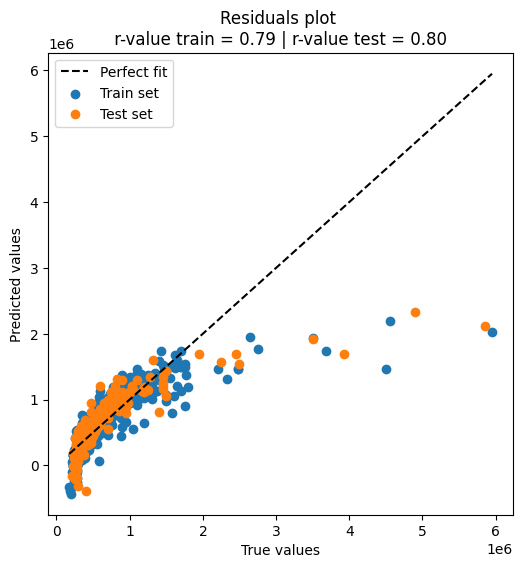

In [8]:
# get model prediction on test set
y_fit = model_fit.predict(X_train_sm)
y_pred = model_fit.predict(X_test_sm)

# plot residuals
fig, ax = plt.subplots(figsize=(6, 6))
ax.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], "--k")
ax.scatter(y_train, y_fit)
ax.scatter(y_test, y_pred)

# add legend
ax.legend(["Perfect fit", "Train set", "Test set"])
ax.set_xlabel("True values")
ax.set_ylabel("Predicted values")
ax.set_title(
    f"Residuals plot \n r-value train = {np.corrcoef(y_train, y_fit)[0,1]:.2f} | r-value test = {np.corrcoef(y_pred, y_test)[0,1]:.2f} "
)

In [9]:
# display report with extended width
with pd.option_context("display.max_colwidth", 1000):
    display(regression_report(y_pred, y_test))

,Score,Description
r-squared,0.014,"Explained variance regression score function. Best possible score is 1.0, lower values are worse."
RMSE,445144.773,Root Mean Squared Error (RMSE)
MAE,204335.178,Mean Absolute Error (MAE)
r-value output,0.799,Correlation between y_true and y_pred


In [17]:
from sklearn.linear_model import Ridge
model = Ridge(alpha=1.0)
model_fit = model.fit(X_train_sm, y_train)

Text(0.5, 1.0, 'Residuals plot \n r-value train = 0.79 | r-value test = 0.80 ')

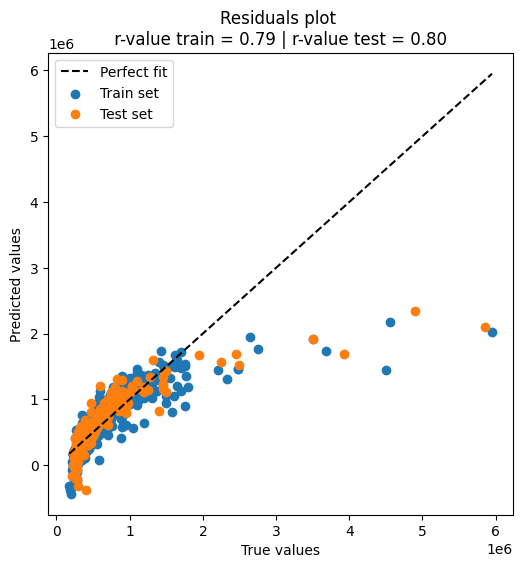

In [18]:
# get model prediction on test set
y_fit = model_fit.predict(X_train_sm)
y_pred = model_fit.predict(X_test_sm)

# plot residuals
fig, ax = plt.subplots(figsize=(6, 6))
ax.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], "--k")
ax.scatter(y_train, y_fit)
ax.scatter(y_test, y_pred)

# add legend
ax.legend(["Perfect fit", "Train set", "Test set"])
ax.set_xlabel("True values")
ax.set_ylabel("Predicted values")
ax.set_title(
    f"Residuals plot \n r-value train = {np.corrcoef(y_train, y_fit)[0,1]:.2f} | r-value test = {np.corrcoef(y_pred, y_test)[0,1]:.2f} "
)

In [19]:
# display report with extended width
with pd.option_context("display.max_colwidth", 1000):
    display(regression_report(y_pred, y_test))

,Score,Description
r-squared,0.007,"Explained variance regression score function. Best possible score is 1.0, lower values are worse."
RMSE,445320.796,Root Mean Squared Error (RMSE)
MAE,203691.922,Mean Absolute Error (MAE)
r-value output,0.799,Correlation between y_true and y_pred


In [20]:
from sklearn.linear_model import Lasso
model = Lasso(alpha=0.1)
model_fit = model.fit(X_train_sm, y_train)

C:\Users\Adobe2023-PC1\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.877e+12, tolerance: 1.731e+10
  model = cd_fast.enet_coordinate_descent(


Text(0.5, 1.0, 'Residuals plot \n r-value train = 0.79 | r-value test = 0.80 ')

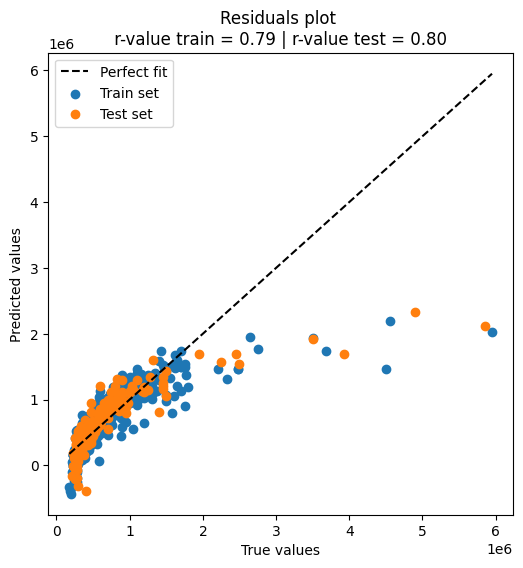

In [21]:
# get model prediction on test set
y_fit = model_fit.predict(X_train_sm)
y_pred = model_fit.predict(X_test_sm)

# plot residuals
fig, ax = plt.subplots(figsize=(6, 6))
ax.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], "--k")
ax.scatter(y_train, y_fit)
ax.scatter(y_test, y_pred)

# add legend
ax.legend(["Perfect fit", "Train set", "Test set"])
ax.set_xlabel("True values")
ax.set_ylabel("Predicted values")
ax.set_title(
    f"Residuals plot \n r-value train = {np.corrcoef(y_train, y_fit)[0,1]:.2f} | r-value test = {np.corrcoef(y_pred, y_test)[0,1]:.2f} "
)

In [22]:
# display report with extended width
with pd.option_context("display.max_colwidth", 1000):
    display(regression_report(y_pred, y_test))

,Score,Description
r-squared,0.014,"Explained variance regression score function. Best possible score is 1.0, lower values are worse."
RMSE,445144.707,Root Mean Squared Error (RMSE)
MAE,204334.679,Mean Absolute Error (MAE)
r-value output,0.799,Correlation between y_true and y_pred
